### Neural Network

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits

%matplotlib inline

np.seterr(all='raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

Qtd Digits:  1797


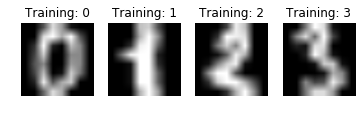

In [159]:
digits = load_digits()
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap='gray', interpolation='bilinear')
    plt.title('Training: %i' % label)

n_samples = len(digits.images)
print('Qtd Digits: ', n_samples)

# Data preparation
# Flatten
X = digits.images.reshape((n_samples, -1))
# Normalization, from 0 to 1
X = X / 255.
# Targets
y = digits.target
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Acurácia: 87.96%
Classification report for classifier 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.88      0.87      0.87        52
           2       0.91      0.79      0.85        53
           3       0.84      0.87      0.85        54
           4       1.00      0.98      0.99        48
           5       0.73      0.86      0.79        57
           6       0.97      0.97      0.97        60
           7       0.94      0.87      0.90        53
           8       0.84      0.85      0.85        61
           9       0.78      0.79      0.78        57

   micro avg       0.88      0.88      0.88       540
   macro avg       0.89      0.88      0.88       540
weighted avg       0.88      0.88      0.88       540


--------------------
Confusion matrix:
[[44  0  0  0  0  0  1  0  0  0]
 [ 0 45  1  0  0  0  1  0  4  1]
 [ 0  2 42  6  0  0  0  0  3  0]
 [ 0  0  2 47  0  1  0  2  0  2]
 [ 0  0  0  0 

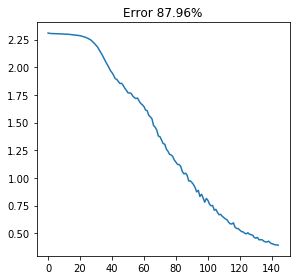

In [162]:
from src.nn import Dense, NeuralNetwork

final_error = []
better_acc = 0

layers = (
    Dense(inputs=64, outputs=100, activation='relu'),
    Dense(inputs=100, outputs=16, activation='relu'), 
    Dense(inputs=16, outputs=10, activation='softmax'), 
)

md = NeuralNetwork(layers, X_train.copy(), y_train.copy(), loss='cross_entropy')
error = md.train(epochs=145, lr=1e-1)

y_pred = md.predict(X_test.copy())

acc = np.round((np.sum(y_pred == y_test) / len(y_test)) * 100, 2)
if acc > better_acc:
    better_acc = acc
final_error = error
print(f'Acurácia: {acc}%')

print("Classification report for classifier \n%s\n"
      % (classification_report(y_test, y_pred)))
print('-' * 20)
print("Confusion matrix:\n%s" % confusion_matrix(y_test, y_pred))

if len(final_error):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'Error {better_acc}%')
    plt.plot(range(len(final_error)), final_error)
    plt.tight_layout()
    plt.show()

Acurácia: 96.11%
--------------------
Classification report for classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size=32, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=1500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       0.84      0.94      0.89        52
           2       0.98      0.91      0.94        53
           3       1.00      0.96      0.98        54
           4       0.91      1.00      0.95        48
           5       0.95      0.98      0.97        57
           6       1.00      0.98      0.99        60
           7       0.98      0.96      0.97  

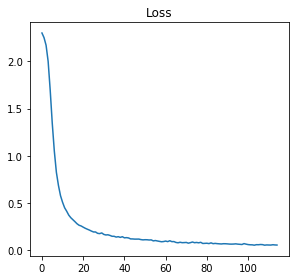

In [161]:
classifier = MLPClassifier(
    max_iter=1500,
    solver='sgd',
    batch_size=32,
    shuffle=True,
    learning_rate_init=1e-1,
    random_state=0
)
classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)

print(f'Acurácia: {np.round(classifier.score(X_test, y_test) * 100, 2)}%')
print('-' * 20)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, classification_report(y_test, predicted)))
print('-' * 20)
print("Confusion matrix:\n%s" % confusion_matrix(y_test, predicted))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f'Loss')
plt.plot(range(classifier.n_iter_), classifier.loss_curve_)
plt.tight_layout()
plt.show()